# Project
Find an interesting topic and try to find research papers that have published the code of the model that
you can download, implement, and run on your machine (try early because sometimes the code does not
work due to incompatible components). Once you have a working code, you should think of variations
you can apply to the code to try ideas to improve the model or apply it to another dataset.


# NLP Text Classification

Problem: Depending on the occurrence of specific words, articles can be categorized under different
topics which is called topic modeling. Similarly, for response generation, emails can be classified under
different categories which can help generate automatic query responses. Previously statistical techniques
and machine learning models were used but these cannot capture the context effectively as deep learning
models can. More recently deep learning models are used to convert words to numeric vector
representations which can capture the context of the word and hence can be used for efficient text
categorization.

# Features added
- Changed from Newsgroup20 dataset to AGNews dataset
- Added dropout to model to incorporate for overfitting
- Batch normalization for each layer in the network
- Added Reduce on platue scheduler to increase efficiency of model training
- Added test function to create a confusion matrix to see accuracy of predictions 


# Potential Datasets:
https://www.kaggle.com/datasets/amananandrai/ag-news-classification-dataset
https://www.kaggle.com/datasets/tboyle10/medicaltranscriptions




In [148]:

import numpy as np # Setup + Library installation
import tensorflow as tf
from tensorflow import keras
import os 
import pathlib
from tensorflow.keras.layers import TextVectorization, Embedding
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import pandas as pd
import keras
from keras import layers
from keras.callbacks import ReduceLROnPlateau
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [93]:

# Download the AG News data and look at the data
# Assuming you have downloaded the AG News dataset and placed it in a directory, modify the path accordingly
ag_news_path = "./ag_news_dataset/"
train_path = os.path.join(ag_news_path, "train.csv")
test_path = os.path.join(ag_news_path, "test.csv")

# Load AG News data
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)

# Display the first few rows of the training dataset
print("AG News Train Data:")
print(train_df.head())

# Display the first few rows of the testing dataset
print("AG News Test Data:")
print(test_df.head())

AG News Train Data:
   Class Index                                              Title  \
0            3  Wall St. Bears Claw Back Into the Black (Reuters)   
1            3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2            3    Oil and Economy Cloud Stocks' Outlook (Reuters)   
3            3  Iraq Halts Oil Exports from Main Southern Pipe...   
4            3  Oil prices soar to all-time record, posing new...   

                                         Description  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  
3  Reuters - Authorities have halted oil export\f...  
4  AFP - Tearaway world oil prices, toppling reco...  
AG News Test Data:
   Class Index                                              Title  \
0            3                  Fears for T N pension after talks   
1            4  The Race is On: Second Private Team Sets Launc...   
2        

In [137]:
# Combine 'Title' and 'Description' columns
train_samples = (train_df['Title'] + ' ' + train_df['Description']).str.replace('\\"', '"').tolist()
test_samples = (test_df['Title'] + ' ' + test_df['Description']).str.replace('\\"', '"').tolist()

# Use 'Class Index' as the label column
train_labels = train_df['Class Index'].tolist()
test_labels = test_df['Class Index'].tolist()
print("Number of training samples:", len(train_samples))
print("Number of testing samples:", len(test_samples))

Number of training samples: 120000
Number of testing samples: 7600


C:\Users\wadeg\AppData\Local\Temp\ipykernel_19952\766695319.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train_samples = (train_df['Title'] + ' ' + train_df['Description']).str.replace('\\"', '"').tolist()
C:\Users\wadeg\AppData\Local\Temp\ipykernel_19952\766695319.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  test_samples = (test_df['Title'] + ' ' + test_df['Description']).str.replace('\\"', '"').tolist()


In [138]:
# Define class names
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# Subtract 1 from label values to make them start from 0
train_labels = np.array(train_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

# Shuffle and split data into training and validation
np.random.seed(seed)
rng = np.random.RandomState(seed)
train_indices = np.arange(len(train_samples))
rng.shuffle(train_indices)

# Extract a training & validation split
validation_split = 0.2
num_validation_samples = int(validation_split * len(train_samples))

train_samples = train_samples[:-num_validation_samples]
val_samples = train_samples[-num_validation_samples:]
train_labels = train_labels[:-num_validation_samples]
val_labels = train_labels[-num_validation_samples:]

# Create a vocabulary index
vectorizer = TextVectorization(max_tokens=20000, output_sequence_length=200)
text_ds = tf.data.Dataset.from_tensor_slices(train_samples).batch(128)
vectorizer.adapt(text_ds)

# Test to retrieve computed vocabulary top 5 words
print(vectorizer.get_vocabulary()[:5])

# Vectorize test sentence
output = vectorizer(["the cat sat on the mat"])
print(output.numpy()[0, :6])

# Dict mapping words to their indices
voc = vectorizer.get_vocabulary()
word_index = dict(zip(voc, range(len(voc))))

test = ["the", "cat", "sat", "on", "the", "mat"]
[word_index[w] for w in test]

['', '[UNK]', 'the', 'to', 'a']
[   2 4887 4651    8    2 9824]


[2, 4887, 4651, 8, 2, 9824]


# Download the GloVe zip file
Invoke-WebRequest -Uri http://nlp.stanford.edu/data/glove.6B.zip -OutFile glove.6B.zip

# Unzip the file
Expand-Archive -Path .\glove.6B.zip -DestinationPath .\


In [139]:
# Construct the full path to the GloVe file
path_to_glove_file = os.path.join(
    os.path.expanduser("~"), "C:/Users/wadeg/Desktop/452/FinalProject/glove.6B.300d.txt"
)

embeddings_index = {}
with open(path_to_glove_file, encoding='utf-8') as f: # UTF-8 for reading txt file
    for line in f:
        word, coefs = line.split(maxsplit=1)
        coefs = np.fromstring(coefs, "f", sep=" ")
        embeddings_index[word] = coefs
        

print("Found %s word vectors." % len(embeddings_index))


Found 400000 word vectors.


In [142]:
# Prepare embedding matrik
num_tokens = len(voc) + 2
embedding_dim = 300
hits = 0
misses = 0

# Prepare embedding matrix
embedding_matrix = np.zeros((num_tokens, embedding_dim))
oov_vector = np.random.rand(embedding_dim)  # Random initialization for OOV words

for word, i in word_index.items():
    # Ensure consistent lowercase representation
    word_lower = word.lower()
    
    embedding_vector = embeddings_index.get(word_lower)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        hits += 1
    else:
        embedding_matrix[i] = oov_vector
        misses += 1

print("Converted %d words (%d misses)" % (hits, misses))

# Load the pre-trained word embeddings matrix into an embedding layer
embedding_layer = Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=keras.initializers.Constant(embedding_matrix),
    trainable=False,
)


Converted 18668 words (1332 misses)


In [145]:
# Input layer for 1D sequences
sequences_input = keras.Input(shape=(None,), dtype="int32")
embedded_sequences = embedding_layer(sequences_input)

# 1D Convolutional layers with Batch Normalization and GlobalMaxPooling1D
x = layers.Conv1D(128, 3, activation="relu")(embedded_sequences)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.MaxPooling1D(2)(x)

x = layers.Conv1D(128, 3, activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.GlobalMaxPooling1D()(x)

# Dense layer with ReLU activation and Dropout
x = layers.Dense(128, activation="relu")(x)
x = layers.Dropout(0.5)(x)

# Output layer
preds = layers.Dense(len(class_names), activation="softmax")(x)

# Model definition
model = keras.Model(sequences_input, preds)
model.summary()


Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, None)]            0         
                                                                 
 embedding_4 (Embedding)     (None, None, 300)         6000600   
                                                                 
 conv1d_27 (Conv1D)          (None, None, 128)         115328    
                                                                 
 batch_normalization_44 (Ba  (None, None, 128)         512       
 tchNormalization)                                               
                                                                 
 max_pooling1d_18 (MaxPooli  (None, None, 128)         0         
 ng1D)                                                           
                                                                 
 conv1d_28 (Conv1D)          (None, None, 128)         492

# Train the model
First, convert our list-of-strings data to NumPy arrays of integer indices. The arrays are right-padded.

In [146]:
x_train = vectorizer(np.array([[s] for s in train_samples])).numpy()
x_val = vectorizer(np.array([[s] for s in val_samples])).numpy()

y_train = np.array(train_labels)
y_val = np.array(val_labels)

We use categorical crossentropy as our loss since we're doing softmax classification. Moreover, we use 'sparse_categorical_crossentropy' since our labels are integers.

In [149]:
# Compile the model with a specified learning rate
initial_learning_rate = 0.001  # You can adjust this value
optimizer = keras.optimizers.Adam(learning_rate=initial_learning_rate)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["acc"])

# Define a learning rate scheduler
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.0001)

# Train the model with the learning rate scheduler
model.fit(x_train, y_train, batch_size=256, epochs=10, validation_data=(x_val, y_val), callbacks=[reduce_lr])

Epoch 1/10
375/375 [==============================] - 58s 151ms/step - loss: 0.4812 - acc: 0.8513 - val_loss: 0.3290 - val_acc: 0.9053 - lr: 0.0010
Epoch 2/10
375/375 [==============================] - 57s 151ms/step - loss: 0.3158 - acc: 0.8960 - val_loss: 0.2309 - val_acc: 0.9245 - lr: 0.0010
Epoch 3/10
375/375 [==============================] - 53s 143ms/step - loss: 0.2815 - acc: 0.9059 - val_loss: 0.1967 - val_acc: 0.9301 - lr: 0.0010
Epoch 4/10
375/375 [==============================] - 53s 143ms/step - loss: 0.2547 - acc: 0.9136 - val_loss: 0.2049 - val_acc: 0.9241 - lr: 0.0010
Epoch 5/10
375/375 [==============================] - 54s 143ms/step - loss: 0.2292 - acc: 0.9208 - val_loss: 0.1655 - val_acc: 0.9387 - lr: 0.0010
Epoch 6/10
375/375 [==============================] - 53s 142ms/step - loss: 0.2102 - acc: 0.9259 - val_loss: 0.1535 - val_acc: 0.9449 - lr: 0.0010
Epoch 7/10
375/375 [==============================] - 54s 145ms/step - loss: 0.1890 - acc: 0.9325 - val_loss: 0.

  1/238 [..............................] - ETA: 6s - loss: 0.1745 - acc: 0.9688

C:\Users\wadeg\AppData\Local\Temp\ipykernel_19952\3025877965.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  x_test = (test_df['Title'] + ' ' + test_df['Description']).str.replace('\\"', '"').tolist()


238/238 [==============================] - 2s 8ms/step - loss: 0.3472 - acc: 0.8954
Test accuracy: 0.8953947424888611
238/238 [==============================] - 2s 8ms/step


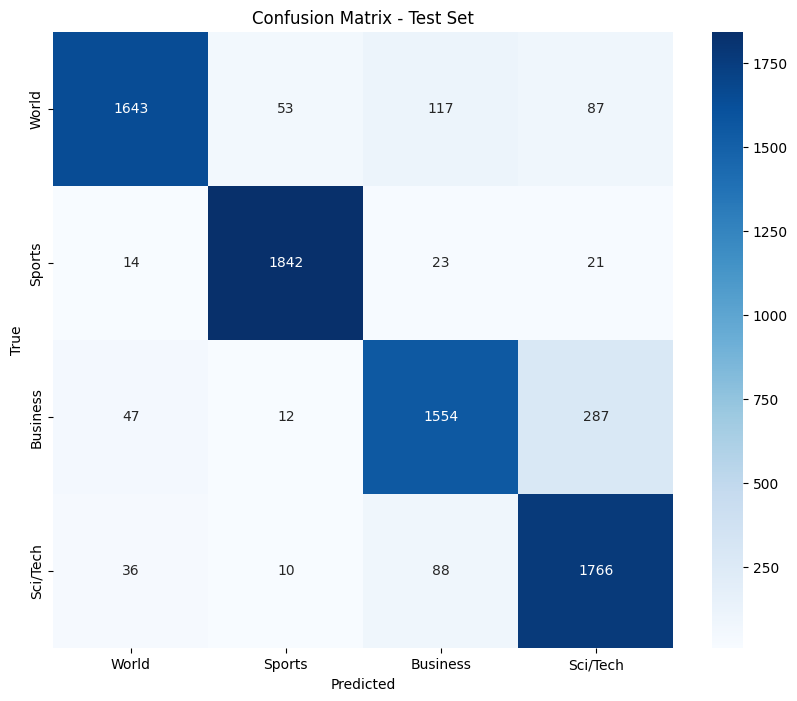

In [150]:
# Split test data into x_test and y_test
x_test = (test_df['Title'] + ' ' + test_df['Description']).str.replace('\\"', '"').tolist()
y_test = np.array(test_df['Class Index'].tolist()) - 1  # Subtract 1 from label values

# Vectorize test data using the same vectorizer
x_test = vectorizer(x_test)

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy:", test_acc)

# Make predictions on the test set
y_pred = model.predict(x_test)
# Assuming y_test and y_pred are in the correct format
confusion = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

# Plot the confusion matrix using seaborn library
plt.figure(figsize=(10, 8))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - Test Set')
plt.savefig('confusion_matrix.png') 
plt.show()



In [169]:
# Define a Keras Input layer for strings with shape (1,)
string_input = keras.Input(shape=(1,), dtype="string")

# Apply the vectorizer layer to convert input strings to sequences of indices
x = vectorizer(string_input)

# Make predictions using the trained model on the vectorized input
preds = model(x)

# Create an end-to-end model that takes a string as input and produces predictions
end_to_end_model = keras.Model(string_input, preds)

# Input a list containing one string to get the predicted probabilities for each class
probabilities = end_to_end_model.predict(
    [["russia bombs ukraine"]]
)

# Retrieve the class name with the highest predicted probability
predicted_class = class_names[np.argmax(probabilities[0])]

# Print the predicted class name
print(predicted_class)


1/1 [==============================] - 0s 224ms/step
World


# References 
Base Code:
https://keras.io/examples/nlp/pretrained_word_embeddings/

Research: 
https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7157505/
